# Objective:

Develop a predictive model to estimate the concentration of NO2 (Nitrogen Dioxide) levels based on meteorological and other air pollutant measurements.

## Goals:
### 1. Create models which work on a single record of data, meaning rolling averages and lags can't be used.
### 2. Time-series forecasting model, where we utilize historical data.

## Import necessary libraries

In [52]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK
import optuna

## Data Acquisition & Preprocessing

In [53]:
base_dir = os.path.dirname(os.getcwd())
xlsx_path = os.path.join(base_dir, 'data', 'raw', 'AirQualityUCI.xlsx')
df = pd.read_excel(xlsx_path)

In [54]:
df.head

<bound method NDFrame.head of            Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0    2004-03-10  18:00:00     2.6      1360.00       150  11.881723   
1    2004-03-10  19:00:00     2.0      1292.25       112   9.397165   
2    2004-03-10  20:00:00     2.2      1402.00        88   8.997817   
3    2004-03-10  21:00:00     2.2      1375.50        80   9.228796   
4    2004-03-10  22:00:00     1.6      1272.25        51   6.518224   
...         ...       ...     ...          ...       ...        ...   
9352 2005-04-04  10:00:00     3.1      1314.25      -200  13.529605   
9353 2005-04-04  11:00:00     2.4      1162.50      -200  11.355157   
9354 2005-04-04  12:00:00     2.4      1142.00      -200  12.374538   
9355 2005-04-04  13:00:00     2.1      1002.50      -200   9.547187   
9356 2005-04-04  14:00:00     2.2      1070.75      -200  11.932060   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
0           1045.50    166.0       1056.25    11

In [55]:
print("\nMissing Values:\n")
print(df.isnull().sum())


Missing Values:

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


Add datetime, weekdays, months and hour to the columns.

In [56]:
datetime_column = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
df.drop(columns=['Date', 'Time'], inplace=True)
df.insert(0, column='Datetime', value=datetime_column)
df.insert(1, column='Weekday', value=df['Datetime'].dt.dayofweek)
df.insert(2, column='Month', value=df['Datetime'].dt.month)
df.insert(3, column='Hour', value=df['Datetime'].dt.hour)

Missing values are tagged with -200 value. Dropping records would result in an inconsistent dataset.

In [57]:
missing_counts = (df == -200).sum()
print(missing_counts)

Datetime            0
Weekday             0
Month               0
Hour                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64


Examine the feature which contains the missing records.

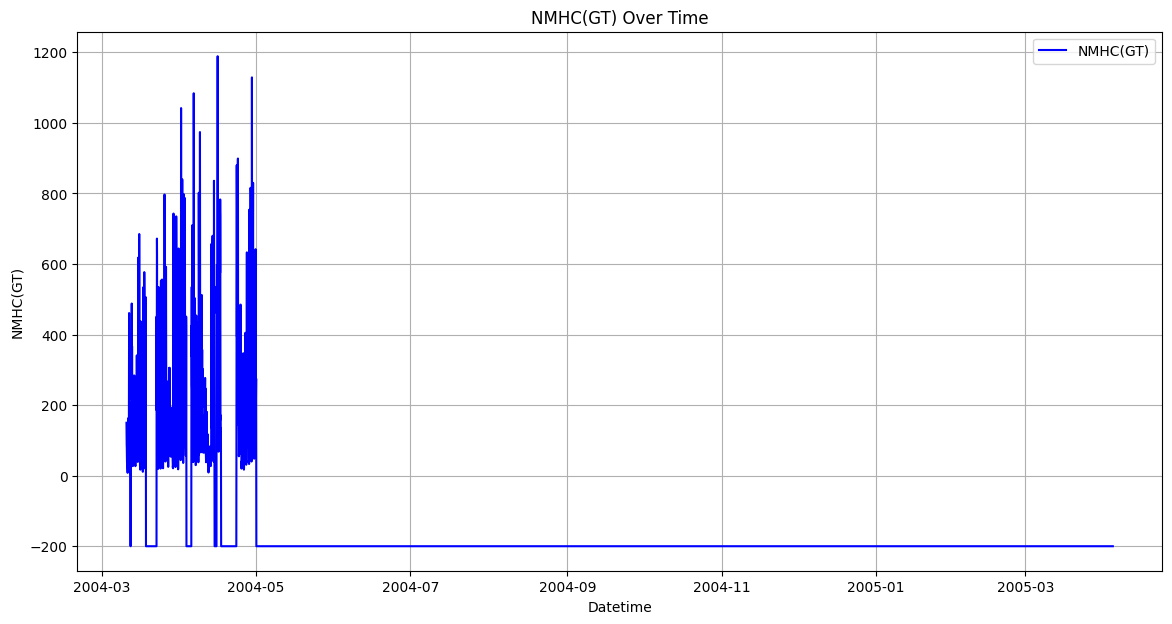

In [58]:
plt.figure(figsize=(14, 7))
plt.plot(df['Datetime'], df['NMHC(GT)'], label='NMHC(GT)', color='blue')
plt.xlabel('Datetime')
plt.ylabel('NMHC(GT)')
plt.title('NMHC(GT) Over Time')
plt.legend()
plt.grid(True)
plt.show()

This amount of spare datas can only be solved with models which can handle NaNs. Replace -200 values with NaN.

In [59]:
df.replace(to_replace=-200, value=np.nan, inplace=True)

Drop records where NO2 values are missing.

In [60]:
df.dropna(subset=['NO2(GT)'], inplace=True)

## EDA

### Data Distribution


Data Distribution:


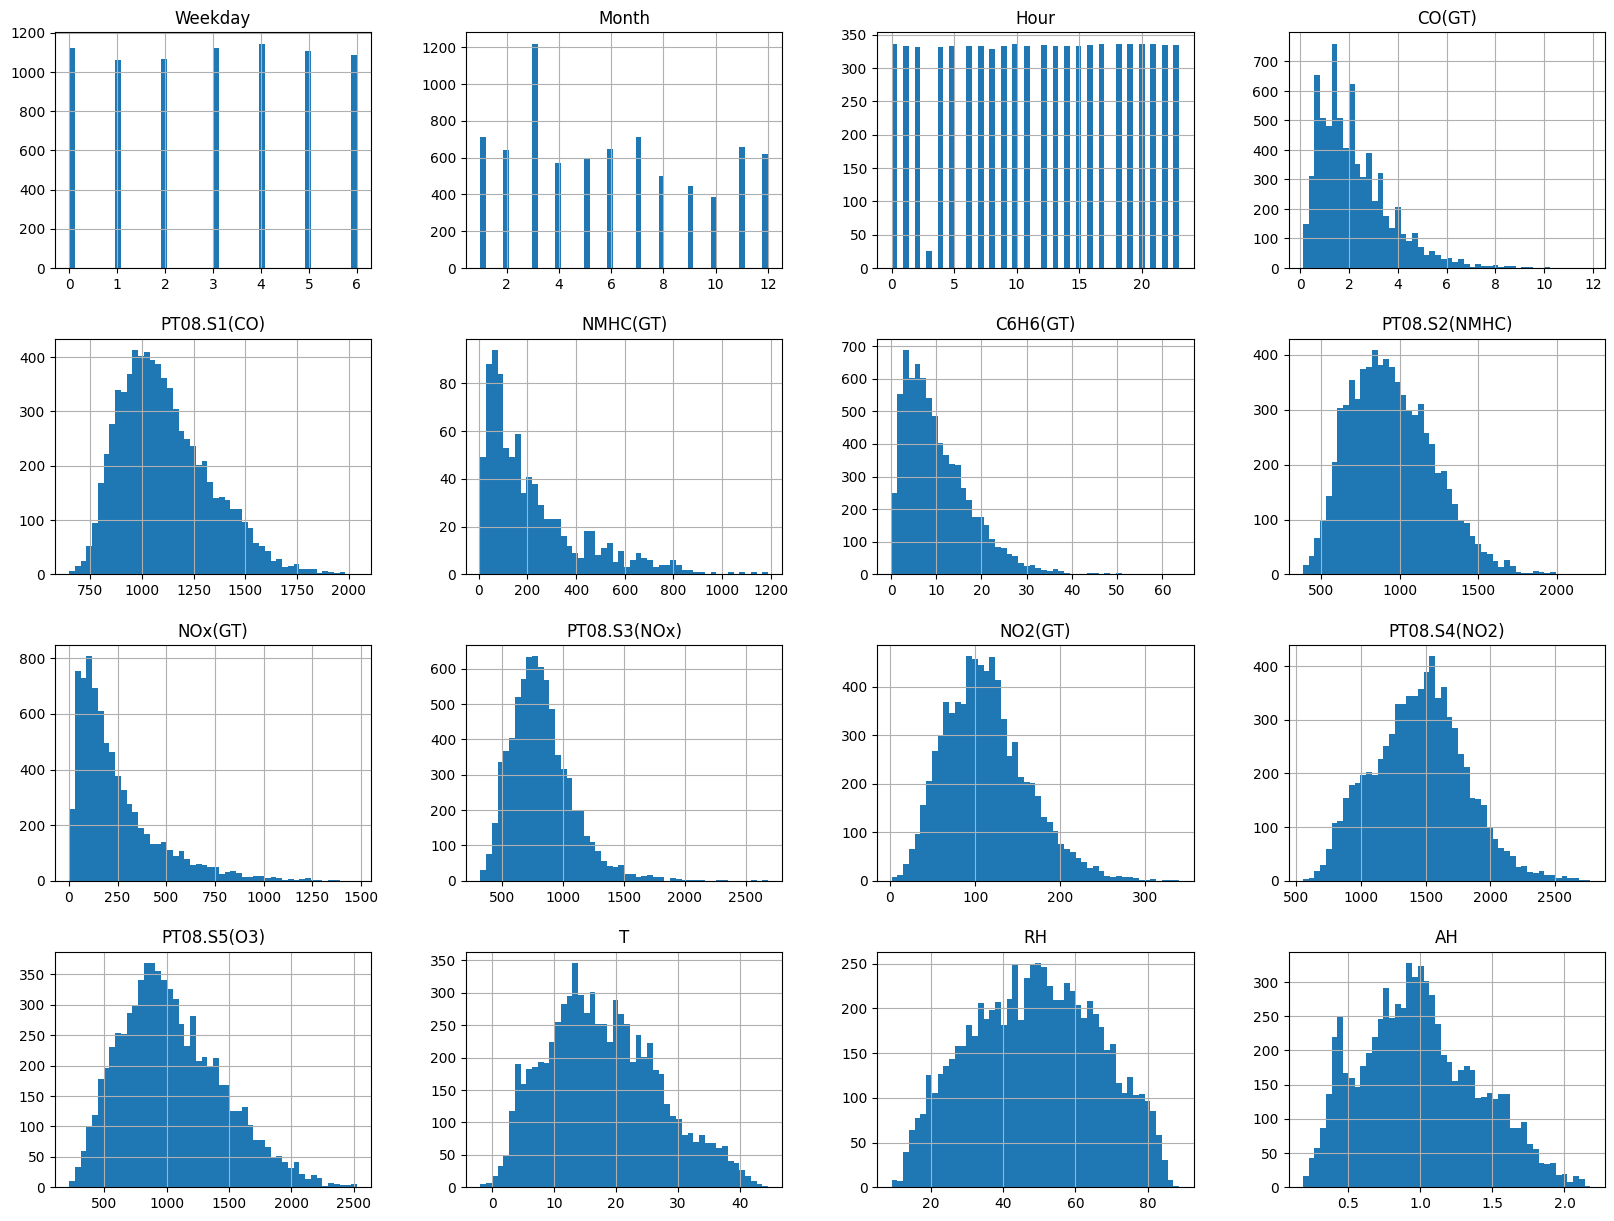

In [61]:
print("\nData Distribution:")
df.drop(columns=['Datetime']).hist(bins=50, figsize=(20, 15))
plt.show()

No outliers

### Correlation Analysis


Correlation Matrix:


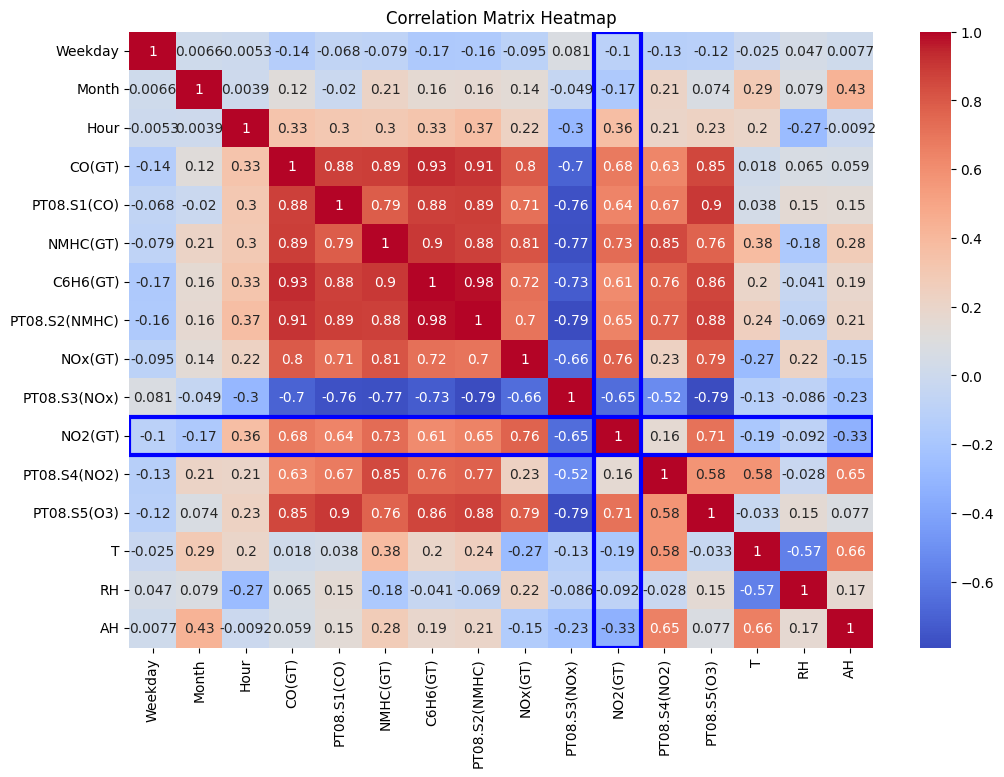

In [62]:
print("\nCorrelation Matrix:")
corr_matrix = df.drop(columns=['Datetime']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Highlight the NO2(GT) column
for i in range(len(corr_matrix.columns)):
    if corr_matrix.columns[i] == 'NO2(GT)':
        plt.gca().add_patch(plt.Rectangle((i, 0), 1, len(corr_matrix.columns), fill=False, edgecolor='blue', lw=3))
        plt.gca().add_patch(plt.Rectangle((0, i), len(corr_matrix.columns), 1, fill=False, edgecolor='blue', lw=3))

plt.title('Correlation Matrix Heatmap')
plt.show()

## 1. Single record model

In [63]:
df.drop(columns=['Datetime'], inplace=True)
df.dropna(subset=['NO2(GT)'], inplace=True)

In [64]:
X = df.drop(columns=['NO2(GT)'])
y = df['NO2(GT)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = pd.DataFrame(X_train)
y_train = pd.Series(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.Series(y_test)

### Generic XGB

In [65]:
xgb_generic = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_generic.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [66]:
y_pred_xgb_generic = xgb_generic.predict(X_test)

In [67]:
rmse_xgb_generic = np.sqrt(mean_squared_error(y_test, y_pred_xgb_generic))
r2_xgb_generic = r2_score(y_test, y_pred_xgb_generic)

print(f'RMSE: {rmse_xgb_generic}')
print(f'R²: {r2_xgb_generic}')

RMSE: 11.934286509726611
R²: 0.9347246964362433


### Tune XGBoost

Define the objective function for Hyperopt

In [68]:
def xgb_objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])

    # XGBoost Regressor with given parameters
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        use_label_encoder=False,
        eval_metric='rmse',
        **params  # Pass the hyperparameter dictionary
    )

    # Cross-validation (important for robust evaluation)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold CV
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)  # Use negative MSE because hyperopt minimizes

    rmse = np.sqrt(-scores.mean()) # Calculate RMSE from negative MSE

    return {'loss': rmse, 'status': STATUS_OK}  # Hyperopt minimizes loss

In [69]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),  # Integer, uniform distribution
    'max_depth': hp.quniform('max_depth', 3, 10, 1),        # Integer, uniform distribution
    'learning_rate': hp.loguniform('learning_rate', -3, 0),    # Logarithmic, uniform distribution
    'gamma': hp.uniform('gamma', 0, 0.5),                    # Uniform distribution
    'subsample': hp.uniform('subsample', 0.6, 1.0),            # Uniform distribution
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0), # Uniform distribution
    'reg_alpha': hp.loguniform('reg_alpha', -5, 0),        # Logarithmic, uniform distribution (L1)
    'reg_lambda': hp.loguniform('reg_lambda', -5, 0),       # Logarithmic, uniform distribution (L2)
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1) # Integer, uniform distribution
}

In [70]:
'''
xgb_tuned_hyperparameters = fmin(
    fn=xgb_objective,
    space=space,
    algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)
    max_evals=100      # Number of iterations
)
'''

'\nxgb_tuned_hyperparameters = fmin(\n    fn=xgb_objective,\n    space=space,\n    algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)\n    max_evals=100      # Number of iterations\n)\n'

In [71]:
'''
print("Tuned hyperparameters:", xgb_tuned_hyperparameters)

# Train the final model with the best hyperparameters
xgb_tuned_params = {k: int(v) if k in ('n_estimators', 'max_depth', 'min_child_weight') else v for k, v in xgb_tuned_hyperparameters.items()} # Convert to correct types

xgb_tuned = xgb.XGBRegressor(
    objective='reg:squarederror', 
    use_label_encoder=False,
    eval_metric='rmse',
    **xgb_tuned_params,  # Use the tuned hyperparameters
    verbosity=0
)

xgb_tuned.fit(X_train, y_train)
y_pred_xgb_tuned = xgb_tuned.predict(X_test)
'''

'\nprint("Tuned hyperparameters:", xgb_tuned_hyperparameters)\n\n# Train the final model with the best hyperparameters\nxgb_tuned_params = {k: int(v) if k in (\'n_estimators\', \'max_depth\', \'min_child_weight\') else v for k, v in xgb_tuned_hyperparameters.items()} # Convert to correct types\n\nxgb_tuned = xgb.XGBRegressor(\n    objective=\'reg:squarederror\', \n    use_label_encoder=False,\n    eval_metric=\'rmse\',\n    **xgb_tuned_params,  # Use the tuned hyperparameters\n    verbosity=0\n)\n\nxgb_tuned.fit(X_train, y_train)\ny_pred_xgb_tuned = xgb_tuned.predict(X_test)\n'

In [72]:
'''
rmse_xgb_tuned = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuned))
r2_xgb_tuned = r2_score(y_test, y_pred_xgb_tuned)

print(f'RMSE: {rmse_xgb_tuned}')
print(f'R²: {r2_xgb_tuned}')
'''

"\nrmse_xgb_tuned = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuned))\nr2_xgb_tuned = r2_score(y_test, y_pred_xgb_tuned)\n\nprint(f'RMSE: {rmse_xgb_tuned}')\nprint(f'R²: {r2_xgb_tuned}')\n"

Save the model with joblib.

In [73]:
# joblib.dump(xgb_tuned, os.path.join(base_dir, 'models', 'xgb_tuned.joblib'))

### Generic LightGBM

In [74]:
lgbm_generic = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, verbose=-1)
lgbm_generic.fit(X_train, y_train)
y_pred_lgbm_generic = lgbm_generic.predict(X_test)
rmse_lgbm_generic = np.sqrt(mean_squared_error(y_test, y_pred_lgbm_generic))
r2_lgbm_generic = r2_score(y_test, y_pred_lgbm_generic)

In [75]:
print(f'LightGBM RMSE: {rmse_lgbm_generic}')
print(f'LightGBM R²: {r2_lgbm_generic}')

LightGBM RMSE: 12.346274548148308
LightGBM R²: 0.9301401190767131


### Tuned LightGBM

In [76]:
def lgbm_objective(trial):
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        lgbm = lgb.LGBMRegressor(**param_grid, random_state=42, n_jobs=-1)
        lgbm.fit(X_train_fold, y_train_fold)

        y_pred = lgbm.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        cv_scores.append(rmse)

    return np.mean(cv_scores)

In [77]:
'''
optuna.logging.set_verbosity(optuna.logging.WARNING)
lgbm_study = optuna.create_study(direction='minimize')  # Minimize RMSE
lgbm_study.optimize(lgbm_objective, n_trials=100)  # Number of trials
'''

"\noptuna.logging.set_verbosity(optuna.logging.WARNING)\nlgbm_study = optuna.create_study(direction='minimize')  # Minimize RMSE\nlgbm_study.optimize(lgbm_objective, n_trials=100)  # Number of trials\n"

In [78]:
'''
print("Best hyperparameters:", lgbm_study.best_params)
print("Best RMSE:", lgbm_study.best_value)
'''

'\nprint("Best hyperparameters:", lgbm_study.best_params)\nprint("Best RMSE:", lgbm_study.best_value)\n'

In [79]:
'''lgbm_tuned = lgb.LGBMRegressor(**lgbm_study.best_params, random_state=42, n_jobs=-1, verbose=-1)
lgbm_tuned.fit(X_train, y_train)'''

'lgbm_tuned = lgb.LGBMRegressor(**lgbm_study.best_params, random_state=42, n_jobs=-1, verbose=-1)\nlgbm_tuned.fit(X_train, y_train)'

In [80]:
#y_pred_lgbm_tuned = lgbm_tuned.predict(X_test)

In [81]:
'''rmse_lgbm_tuned = np.sqrt(mean_squared_error(y_test, y_pred_lgbm_tuned))
r2_lgbm_tuned = r2_score(y_test, y_pred_lgbm_tuned)
print(f'Tuned LGBM RMSE: {rmse_lgbm_tuned}')
print(f'Tuned LGBM R²: {r2_lgbm_tuned}')'''

"rmse_lgbm_tuned = np.sqrt(mean_squared_error(y_test, y_pred_lgbm_tuned))\nr2_lgbm_tuned = r2_score(y_test, y_pred_lgbm_tuned)\nprint(f'Tuned LGBM RMSE: {rmse_lgbm_tuned}')\nprint(f'Tuned LGBM R²: {r2_lgbm_tuned}')"

Save the model.

In [82]:
#joblib.dump(lgbm_tuned, os.path.join(base_dir, 'models', 'lgbm_tuned.joblib'))

### CatBoost

In [83]:
catboost_generic = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=0)
catboost_generic.fit(X_train, y_train)
y_pred_catboost_generic = catboost_generic.predict(X_test)
rmse_catboost_generic = np.sqrt(mean_squared_error(y_test, y_pred_catboost_generic))
r2_catboost_generic = r2_score(y_test, y_pred_catboost_generic)

In [84]:
print(f'CatBoost RMSE: {rmse_catboost_generic}')
print(f'CatBoost R²: {r2_catboost_generic}')

CatBoost RMSE: 13.559195222005723
CatBoost R²: 0.9157395434855243


### Tuned CatBoost

In [85]:
def catboost_objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 1e-2, 1.0, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'verbose': 0
    }
    
    model = CatBoostRegressor(**param)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)
    
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

In [86]:
'''catboost_study = optuna.create_study(direction='minimize')
catboost_study.optimize(catboost_objective, n_trials=100)'''

"catboost_study = optuna.create_study(direction='minimize')\ncatboost_study.optimize(catboost_objective, n_trials=100)"

In [87]:
'''print("Best hyperparameters: ", catboost_study.best_params)'''

'print("Best hyperparameters: ", catboost_study.best_params)'

In [88]:
'''catboost_tuned_params = catboost_study.best_params
catboost_tuned_params['verbose'] = 0
catboost_tuned = CatBoostRegressor(**catboost_tuned_params)
catboost_tuned.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

y_pred_catboost_tuned = catboost_tuned.predict(X_test)
rmse_catboost_tuned = mean_squared_error(y_test, y_pred_catboost_tuned, squared=False)
r2_catboost_tuned = r2_score(y_test, y_pred_catboost_tuned)

print(f"Final RMSE: {rmse_catboost_tuned}")
print(f"Final R2: {r2_catboost_tuned}")'''

'catboost_tuned_params = catboost_study.best_params\ncatboost_tuned_params[\'verbose\'] = 0\ncatboost_tuned = CatBoostRegressor(**catboost_tuned_params)\ncatboost_tuned.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)\n\ny_pred_catboost_tuned = catboost_tuned.predict(X_test)\nrmse_catboost_tuned = mean_squared_error(y_test, y_pred_catboost_tuned, squared=False)\nr2_catboost_tuned = r2_score(y_test, y_pred_catboost_tuned)\n\nprint(f"Final RMSE: {rmse_catboost_tuned}")\nprint(f"Final R2: {r2_catboost_tuned}")'

In [89]:
#joblib.dump(catboost_tuned, os.path.join(base_dir, 'models', 'catboost_tuned.joblib'))

### Visualization

In [90]:
'''plt.figure(figsize=(15, 5))

# XGBoost
plt.subplot(1, 3, 1)
plt.plot(y_test.values[:50], label='Real Values')
plt.plot(y_pred_xgb_tuned[:50], label='Predicted Values')
plt.title('XGBoost Predictions')
plt.xlabel('Sample Index')
plt.ylabel('NO2(GT)')
plt.legend()

# LightGBM
plt.subplot(1, 3, 2)
plt.plot(y_test.values[:50], label='Real Values')
plt.plot(y_pred_lgbm_tuned[:50], label='Predicted Values')
plt.title('LightGBM Predictions')
plt.xlabel('Sample Index')
plt.ylabel('NO2(GT)')
plt.legend()

# CatBoost
plt.subplot(1, 3, 3)
plt.plot(y_test.values[:50], label='Real Values')
plt.plot(y_pred_catboost_tuned[:50], label='Predicted Values')
plt.title('CatBoost Predictions')
plt.xlabel('Sample Index')
plt.ylabel('NO2(GT)')
plt.legend()

plt.tight_layout()
plt.show()'''

"plt.figure(figsize=(15, 5))\n\n# XGBoost\nplt.subplot(1, 3, 1)\nplt.plot(y_test.values[:50], label='Real Values')\nplt.plot(y_pred_xgb_tuned[:50], label='Predicted Values')\nplt.title('XGBoost Predictions')\nplt.xlabel('Sample Index')\nplt.ylabel('NO2(GT)')\nplt.legend()\n\n# LightGBM\nplt.subplot(1, 3, 2)\nplt.plot(y_test.values[:50], label='Real Values')\nplt.plot(y_pred_lgbm_tuned[:50], label='Predicted Values')\nplt.title('LightGBM Predictions')\nplt.xlabel('Sample Index')\nplt.ylabel('NO2(GT)')\nplt.legend()\n\n# CatBoost\nplt.subplot(1, 3, 3)\nplt.plot(y_test.values[:50], label='Real Values')\nplt.plot(y_pred_catboost_tuned[:50], label='Predicted Values')\nplt.title('CatBoost Predictions')\nplt.xlabel('Sample Index')\nplt.ylabel('NO2(GT)')\nplt.legend()\n\nplt.tight_layout()\nplt.show()"

In [91]:
'''results = pd.DataFrame({
    'Model': ['Generic XGB', 'Tuned XGB', 'Generic LGBM', 'Tuned LGBM', 'Generic CatBoost', 'Tuned CatBoost'],
    'RMSE': [rmse_xgb_generic, rmse_xgb_tuned, rmse_lgbm_generic, rmse_lgbm_tuned, rmse_catboost_generic, rmse_catboost_tuned],
    'R2': [r2_xgb_generic, r2_xgb_tuned, r2_lgbm_generic, r2_lgbm_tuned, r2_catboost_generic, r2_catboost_tuned]
})

print(results)'''

"results = pd.DataFrame({\n    'Model': ['Generic XGB', 'Tuned XGB', 'Generic LGBM', 'Tuned LGBM', 'Generic CatBoost', 'Tuned CatBoost'],\n    'RMSE': [rmse_xgb_generic, rmse_xgb_tuned, rmse_lgbm_generic, rmse_lgbm_tuned, rmse_catboost_generic, rmse_catboost_tuned],\n    'R2': [r2_xgb_generic, r2_xgb_tuned, r2_lgbm_generic, r2_lgbm_tuned, r2_catboost_generic, r2_catboost_tuned]\n})\n\nprint(results)"

Tuned Catboost model produced the best results.

# 2. Time-series forecasting.

Add a rolling average and lag feature of NO2.

In [92]:
df['NO2_6hr_avg'] = df['NO2(GT)'].rolling(window=6, min_periods=6).mean().shift(1)
df['NO2_3hr_avg'] = df['NO2(GT)'].rolling(window=3, min_periods=3).mean().shift(1)
df['NO2_1hr_lag'] = df['NO2(GT)'].shift(1)

In [93]:
print(df[['NO2(GT)', 'NO2_6hr_avg', 'NO2_3hr_avg', 'NO2_1hr_lag']].head(20))

    NO2(GT)  NO2_6hr_avg  NO2_3hr_avg  NO2_1hr_lag
0     113.0          NaN          NaN          NaN
1      92.0          NaN          NaN        113.0
2     114.0          NaN          NaN         92.0
3     122.0          NaN   106.333333        114.0
4     116.0          NaN   109.333333        122.0
5      96.0          NaN   117.333333        116.0
6      77.0   108.833333   111.333333         96.0
7      76.0   102.833333    96.333333         77.0
8      60.0   100.166667    83.000000         76.0
10     34.0    91.166667    71.000000         60.0
11     28.0    76.500000    56.666667         34.0
12     48.0    61.833333    40.666667         28.0
13     82.0    53.833333    36.666667         48.0
14    112.0    54.666667    52.666667         82.0
15    101.0    60.666667    80.666667        112.0
16     98.0    67.500000    98.333333        101.0
17     92.0    78.166667   103.666667         98.0
18     95.0    88.833333    97.000000         92.0
19    112.0    96.666667    95.

In [94]:
train_size = int(0.8 * len(df))  # 80% Train, 20% Test

train_df = df.iloc[:train_size]  # First 80% as Training
test_df = df.iloc[train_size:]   # Last 20% as Testing

In [95]:
X_train_time = train_df.drop(columns=['NO2(GT)'])
y_train_time = train_df['NO2(GT)']
X_test_time = test_df.drop(columns=['NO2(GT)'])
y_test_time = test_df['NO2(GT)']

In [96]:
train_features = X_train_time.columns.tolist()

In [97]:
# plot NO2(GT) with points, 'NO2_3hr_avg' and 'NO2_6hr_avg'

## XGB

In [98]:
def xgb_time_objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])

    model = xgb.XGBRegressor(objective='reg:squarederror', **params)
    model.fit(X_train_time, y_train_time)
    y_pred_time = model.predict(X_test_time)
    rmse = np.sqrt(mean_squared_error(y_test_time, y_pred_time))
    
    return {'loss': rmse, 'status': STATUS_OK}

In [99]:
xgb_time_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, 0),
    'reg_lambda': hp.loguniform('reg_lambda', -5, 0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1)
}

In [100]:
tuned_params_xgb_time = fmin(fn=xgb_objective, space=xgb_time_space, algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [06:26<00:00,  3.86s/trial, best loss: 11.308764213769646]


In [101]:
tuned_params_xgb_time = {k: int(v) if k in ('n_estimators', 'max_depth', 'min_child_weight') else v for k, v in tuned_params_xgb_time.items()}
xgb_time_tuned = xgb.XGBRegressor(objective='reg:squarederror', **tuned_params_xgb_time)
xgb_time_tuned.fit(X_train_time, y_train_time)
joblib.dump(xgb_time_tuned, os.path.join(base_dir, 'models', "xgb_time_tuned.joblib"))

['c:\\Users\\uif93590\\Desktop\\SoftwareProjects\\air-quality\\models\\xgb_time_tuned.joblib']

## LGBM

In [ ]:
def lgbm_time_objective(trial):
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)
    }

    model = lgb.LGBMRegressor(**param_grid)
    model.fit(X_train_time, y_train_time)
    y_pred_time = model.predict(X_test_time)
    return np.sqrt(mean_squared_error(y_test_time, y_pred_time))

In [ ]:
lgbm_time_study = optuna.create_study(direction='minimize')
lgbm_time_study.optimize(lgbm_time_objective, n_trials=100)

In [ ]:
lgbm_time_params = lgbm_time_study.best_params
lgbm_time_tuned = lgb.LGBMRegressor(**lgbm_time_params)
lgbm_time_tuned.fit(X_train_time, y_train_time)
joblib.dump(lgbm_time_tuned, os.path.join(base_dir, 'models', "lgbm_time_tuned.joblib"))

['lgbm_time_tuned.joblib']

## CatBoost

In [ ]:
def catboost_time_objective(trial):
    param_grid = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 1e-2, 1.0, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'verbose': 0
    }

    model = CatBoostRegressor(**param_grid)
    model.fit(X_train_time, y_train_time)
    y_pred_time = model.predict(X_test_time)
    return np.sqrt(mean_squared_error(y_test_time, y_pred_time))

In [ ]:
catboost_time_study = optuna.create_study(direction='minimize')
catboost_time_study.optimize(catboost_time_objective, n_trials=100)

In [ ]:
catboost_time_params = catboost_time_study.best_params
catboost_time_tuned = CatBoostRegressor(**catboost_time_params)
catboost_time_tuned.fit(X_train_time, y_train_time)
joblib.dump(catboost_time_tuned, os.path.join(base_dir, 'models', "catboost_time.joblib"))

0:	learn: 41.4578149	total: 6.43ms	remaining: 5.37s
1:	learn: 39.6366824	total: 14.1ms	remaining: 5.86s
2:	learn: 37.9145595	total: 19ms	remaining: 5.26s
3:	learn: 36.2862237	total: 28.2ms	remaining: 5.86s
4:	learn: 34.7545676	total: 33.9ms	remaining: 5.63s
5:	learn: 33.2975711	total: 39.1ms	remaining: 5.41s
6:	learn: 31.9030478	total: 43.1ms	remaining: 5.11s
7:	learn: 30.6029971	total: 49.2ms	remaining: 5.09s
8:	learn: 29.3582094	total: 53.9ms	remaining: 4.95s
9:	learn: 28.1873376	total: 57.2ms	remaining: 4.73s
10:	learn: 27.0774333	total: 61.1ms	remaining: 4.58s
11:	learn: 26.0255880	total: 65.2ms	remaining: 4.48s
12:	learn: 25.0381665	total: 69ms	remaining: 4.37s
13:	learn: 24.0992627	total: 72.4ms	remaining: 4.25s
14:	learn: 23.2267055	total: 76.5ms	remaining: 4.19s
15:	learn: 22.3878650	total: 79.8ms	remaining: 4.09s
16:	learn: 21.6016835	total: 83.1ms	remaining: 4s
17:	learn: 20.8574016	total: 86.1ms	remaining: 3.91s
18:	learn: 20.1709476	total: 89.2ms	remaining: 3.83s
19:	learn:

['catboost_time.joblib']

## Evalution

In [103]:
models = {
    "Tuned XGBoost": xgb_time_tuned,
    #"Tuned LightGBM": lgbm_time_tuned,
    #"Tuned CatBoost": catboost_time_tuned
}

for name, model in models.items():
    y_pred_time = model.predict(X_test_time)
    rmse = np.sqrt(mean_squared_error(y_test_time, y_pred_time))
    r2 = r2_score(y_test_time, y_pred_time)
    print(f"{name} -> RMSE: {rmse:.4f}, R²: {r2:.4f}")

Tuned XGBoost -> RMSE: 24.3797, R²: 0.7954
